In [382]:
import numpy as np
from datetime import datetime as dt,timedelta
import xarray as xr
import netCDF4 as nc
import os
import copy
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cftime
# import xesmf as xe
import matplotlib.pyplot as plt


In [3]:
from lib import driver
# from lib import plot 
from lib.tools import get_categorical_obs, get_categorical_fcst, get_heidke, get_rpss
# from lib import verif
from lib.tools import *

ERROR 1: PROJ: proj_create_from_database: Open of /home/ycheng/.conda/envs/cpc/share/proj failed


In [4]:
from lib import getCPCobs
from lib.getCPCobs import *

In [5]:
def interp2CPC(lat,lon,z):
    print('---------- interp2CPC ----------')

    xMin = max([0,min(lon)-5])
    yMin = max([-90,min(lat)-5])
    xMax = min([360,max(lon)+5])
    yMax = min([90,max(lat)+5])

    # grid the data.
    zLL = z[np.argmin((lon-xMin)**2+(lat-yMin)**2)]
    zLR = z[np.argmin((lon-xMax)**2+(lat-yMin)**2)]
    zUL = z[np.argmin((lon-xMin)**2+(lat-yMax)**2)]
    zUR = z[np.argmin((lon-xMax)**2+(lat-yMax)**2)]
    lonNew = np.array(list(lon)+[xMin,xMax,xMin,xMax])
    latNew = np.array(list(lat)+[yMin,yMin,yMax,yMax])
    zNew = np.array(list(z)+[zLL,zLR,zUL,zUR])

    zmap = griddata((lonNew,latNew), zNew, (cpcmask.lon.data[None,:], cpcmask.lat.data[:,None]), method='cubic')

    # out = zmap[np.where(~np.isnan(cpcmask.mask1.data))]
    out = zmap[np.where(~np.isnan(cpcmask.mask.data))]

    return out

def fillnan(a):
    amask = np.isnan(a)
    a[amask] = np.interp(np.flatnonzero(amask), np.flatnonzero(~amask), a[~amask])
    return a

In [6]:
# LIMdriver = driver.Driver('namelist_retrospective.py')
LIMdriver = driver.Driver(f'namelist_retrospective_11a_no_SOIL.py')
LIMdriver.get_variables(read=True)


reading  /Projects/jalbers_process/CPC_LIM/yuan_ming/Data/11a_no_SOIL/data_clim/tmp/fullyr_JRA_58-16_sliding_climo_SST.p
reading  /Projects/jalbers_process/CPC_LIM/yuan_ming/Data/11a_no_SOIL/data_clim/tmp/fullyr_JRA_58-16_sliding_climo_SF750.p
reading  /Projects/jalbers_process/CPC_LIM/yuan_ming/Data/11a_no_SOIL/data_clim/tmp/fullyr_JRA_58-16_sliding_climo_SF100.p
reading  /Projects/jalbers_process/CPC_LIM/yuan_ming/Data/11a_no_SOIL/data_clim/tmp/fullyr_JRA_58-16_sliding_climo_T2m.p
reading  /Projects/jalbers_process/CPC_LIM/yuan_ming/Data/11a_no_SOIL/data_clim/tmp/fullyr_JRA_58-16_sliding_climo_SLP.p
reading  /Projects/jalbers_process/CPC_LIM/yuan_ming/Data/11a_no_SOIL/data_clim/tmp/fullyr_JRA_58-16_sliding_climo_H500.p
reading  /Projects/jalbers_process/CPC_LIM/yuan_ming/Data/11a_no_SOIL/data_clim/tmp/fullyr_JRA_58-16_sliding_climo_colIrr.p


Read in the cpcmask_ori, which has lat -88 - 88; lon 0 - 360
Create a new ds with lat -90 - 90; lon 0 - 358
Mannually assgin the cpcmask_ori.mask1 to ds.mask.
The new mask and the original look identical over the US.

<xarray.DataArray 'mask1' (lat: 89, lon: 181)>
[16109 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0 360.0
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0 <xarray.DataArray 'mask1' (lat: 89, lon: 181)>
[16109 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0 360.0
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
<xarray.DataArray 'mask' (lat: 91, lon: 180)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 35

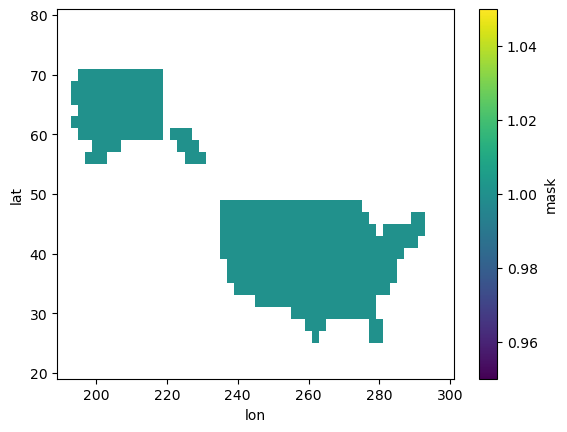

In [48]:
cpcmask_ori = xr.open_dataset('data_clim/cpcmask.nc')
new_lat= np.linspace(-90, 90, 91)
new_lon= np.linspace(0, 358, 180)
# cpcmask_expand = np.full((len(new_lat), len(new_lon)),np.nan)
# print(cpcmask_expand.shape,cpcmask_ori['mask1'].shape)
print(cpcmask_ori['mask1'], cpcmask_ori['mask1'])
ds = xr.Dataset()
ds['mask'] = (('lat','lon'),np.full((len(new_lat), len(new_lon)),np.nan))
ds['lat'], ds['lon'] = new_lat,new_lon
ds['mask'][1:90] = cpcmask_ori.mask1.sel(lat=slice(-88,88),lon=slice(0,358))
print(ds['mask'])
print(ds['mask'][1:90])
# Create a new dataset with values replaced based on the condition
# updated_ds = ds.where(condition, cpcmask_ori['mask1'])
# cpcmask_interp = cpcmask_ori['mask1'].interp(lat=new_lat,lon=new_lon)
ds.mask.sel(lat=slice(20,80),lon=slice(190,300)).plot()
ds.to_netcdf('data_clim/cpcmask_T2m_grid.nc')


In [430]:
cpcmask = xr.open_dataset('data_clim/cpcmask_T2m_grid.nc')


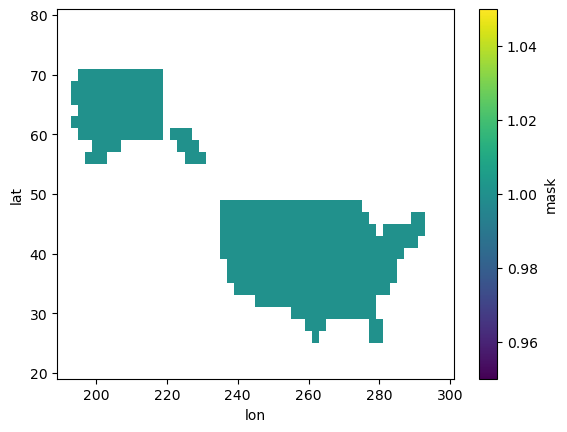

In [432]:
cpcmask.mask.sel(lat=slice(20,80),lon=slice(190,300)).plot()


These are some codes to change John's mask from 0, 1 to nan, 1. 
There is some issue with the direction of lat and the dims are not compatible with T2m.
So I switched back to Sam's mask, which has a better Florida and SE Alaska.

In [367]:

# temp = xr.DataArray(cpcmask['mask'].data, coords=[cpcmask['lats'].data, cpcmask['lons'].data], dims=['lat', 'lon'])
# ds = xr.Dataset(data_vars={'mask': temp})
# cpcmask_new = xr.Dataset(
#     {
#         "lat": (["lat"], cpcmask['lats'].data, {"units": "degrees_north"}),
#         "lon": (["lon"], cpcmask['lons'].data, {"units": "degrees_east"}),
#     }
# )
# cpcmask_nan = xr.where(ds == 0.,np.nan,ds)
# cpcmask_nan.to_netcdf('data_clim/usa_mask.grid2_nan.nc')

cpcmask_j = xr.open_dataset('data_clim/usa_mask.grid2_nan.nc')
# cpcmask_nan_read.mask.plot(lat=slice(20,80))
# cpcmask_nan_read.lon
# cpcmask_nan_read.lat

# cpcmask = cpcmask_nan_read

In [51]:
varname = 'T2m'
varobj = LIMdriver.use_vars[varname]['data']
limlon = varobj.lon
limlat = varobj.lat
cpcmask = xr.open_dataset('data_clim/cpcmask_T2m_grid.nc')
pthresh = 55


In [52]:
T_START = dt(2017,1,1) #dt(YEAR,MONTH,1)
# T_START = dt(2017,10,13) #dt(YEAR,MONTH,1)
T_END = dt(2017,12,31) #dt(YEAR,MONTH,LASTDAY)

now = dt.now()
endyear = np.min([now.year+1,int(T_END.year)+2])
years =  np.arange( int(T_START.year),endyear,1)

In [416]:
climP.lat

<xarray.DataArray 'lat' (lat: 91)>
array([-90., -88., -86., -84., -82., -80., -78., -76., -74., -72., -70., -68.,
       -66., -64., -62., -60., -58., -56., -54., -52., -50., -48., -46., -44.,
       -42., -40., -38., -36., -34., -32., -30., -28., -26., -24., -22., -20.,
       -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,
         6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,
        30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,  48.,  50.,  52.,
        54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,  72.,  74.,  76.,
        78.,  80.,  82.,  84.,  86.,  88.,  90.])
Coordinates:
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0

In [53]:
clim = xr.open_dataset('/Projects/jalbers_process/CPC_data/temp.climo.grid2-areaAvg.1991to2020.nc')
dates = xr.cftime_range(start='0001-01-01', end='0001-12-31', freq='D')
clim = xr.DataArray(clim.climo, dims=['time','lat','lon'], 
                      coords={'time': dates, 'lat': clim.lat, 'lon': clim.lon})
clim = xr.Dataset(data_vars={'tavg': clim})
clim = xr.concat([clim,clim],dim='time') # probably to avoid end point problems in rolling mean
# climroll = clim.drop_vars(['climatology_bounds']).rolling({'time':7},min_periods=int(7//2)).mean()
climroll = clim.rolling({'time':7},min_periods=int(7//2)).mean()
climatology = climroll.groupby("time.dayofyear").mean("time")
# climP = xr.open_dataset('data_clim/tavg.day.1981-2010.ltm.nc')
climP = xr.open_dataset('/Projects/jalbers_process/CPC_data/temp.climo.grid2-areaAvg.1981to2010.nc')
climP = xr.DataArray(climP.climo, dims=['time','lat','lon'], 
                      coords={'time': dates, 'lat': climP.lat, 'lon': climP.lon})
climP = xr.Dataset(data_vars={'tavg': climP})

climP = xr.concat([climP,climP],dim='time')
# climProll = climP.drop_vars(['climatology_bounds']).rolling({'time':7},min_periods=int(7//2)).mean()
climProll = climP.rolling({'time':7},min_periods=int(7//2)).mean()
climatologyP = climProll.groupby("time.dayofyear").mean("time")

In [54]:
now = dt.now()
endyear = np.min([now.year+1,int(T_END.year)+2])
years =  np.arange( int(T_START.year),endyear,1)

ds1 = xr.open_mfdataset([f'data_retrospective/cpctmin.{year}.nc' for year in years])
ds2 = xr.open_mfdataset([f'data_retrospective/cpctmax.{year}.nc' for year in years])
ds3 = ds1.merge(ds2,compat='override')
ds4 = ds3.assign(tavg=(("time", "lat", "lon"),np.nanmean([ds3.tmin,ds3.tmax],axis=0)))
obs = ds4.drop(('tmin','tmax'))
newlat, newlon = clim['lat'].data, clim['lon'].data
obs_interp = obs.interp(lat=newlat,lon=newlon)
obs = obs_interp


In [55]:
obsroll = obs.rolling({'time':7},min_periods=int(7//2)).mean()
obsroll = obsroll.assign_coords({'dayofyear':('time',[(t.dayofyear-1)%365+1 for t in pd.DatetimeIndex(obsroll.time.data)])})
obsgroup = obsroll.groupby("dayofyear")

anom = obsgroup-climatology
anomP = obsgroup-climatologyP

In [56]:
print(anom['tavg'].shape)
climP['tavg'].shape

(730, 91, 180)


(730, 91, 180)

In [57]:
newlat, newlon = clim['lat'].data, clim['lon'].data
obs_interp = obs.interp(lat=newlat,lon=newlon)
obs_interp


<xarray.Dataset>
Dimensions:  (time: 730, lat: 91, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    tavg     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 20:49:50
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

In [ ]:
# obs_interp.tavg.sel(time=slice("2017-01-01", "2017-1-15")).plot(col="time",col_wrap=6, robust=True)

In [ ]:
# interp_out = xr.Dataset(
#     {
#         "lat": (["lat"], clim['lat'].data, {"units": "degrees_north"}),
#         "lon": (["lon"], clim['lon'].data, {"units": "degrees_east"}),
#     }
# )
# interp_out
# regridder = xe.Regridder(obs, interp_out, "bilinear")
# regridder  # print basic regridder information.
# obs_interp = regridder(obs['tavg'], keep_attrs=True)


In [ ]:
obs = obs_interp

In [ ]:
clim['tavg'].shape

(730, 91, 180)

In [ ]:
obs['tavg'].shape

(730, 91, 180)

In [ ]:
obsroll = obs.rolling({'time':7},min_periods=int(7//2)).mean()
obsroll = obsroll.assign_coords({'dayofyear':('time',[(t.dayofyear-1)%365+1 for t in pd.DatetimeIndex(obsroll.time.data)])})
obsgroup = obsroll.groupby("dayofyear")

In [61]:
anom = obsgroup-climatology
anom
tmp = anom

In [ ]:
test = anom.tavg[10]
# a = test*cpcmask_nan_read['mask'].data
a = test
a = np.array(a)
non_nan_elements = a[~np.isnan(a)]
print(non_nan_elements)
# anom['tavg'][10].plot()

# a_retain = np.array(a)[~np.isnan(np.array(a))]
# a_retain.shape


[-275.46619189 -275.1559371  -276.22140982 ... -272.35488021 -272.65572503
 -272.97871887]


In [ ]:
# latbins = np.mean([cpcmask.lat.data[:-1],cpcmask.lat.data[1:]],axis=0)
# lonbins = np.mean([cpcmask.lon.data[:-1],cpcmask.lon.data[1:]],axis=0)

# tmpC = anom.groupby_bins('lat',latbins).mean()
# tmpC = tmpC.groupby_bins('lon',lonbins).mean()
# tmpC['lat'] = cpcmask.lat.data[1:-1]
# tmpC['lon'] = cpcmask.lon.data[1:-1]
# tmpC['tavg'] = tmpC['tavg'].T

In [60]:
# tmp = tmpC
a = np.mean([tmp.isel(time=0).tavg.data],axis=0)
print(a.shape)
# a = a*cpcmask.mask1.data[1:-1,1:-1]
a = a*cpcmask.mask.data
print(a.shape)

whereNan = np.argwhere(~np.isnan(a))
whereNan.shape
# ilat,ilon = [*zip(*whereNan)]
# z = a[min(ilat):max(ilat)+1,min(ilon):max(ilon)+1]
# lat = latbins[min(ilat):max(ilat)+2]
# lon = lonbins[min(ilon):max(ilon)+2]

(91, 180)
(91, 180)


(0, 2)

In [410]:
LIMpage_path = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_retrospective_8_vars_9e_sliding_climo_no_double_running_mean_add_offset_simple_map'

FCSTDIR = f'{LIMpage_path}/lim_t2m_retrospective/wk34separate_regression' 
VERIFDIR = f'{FCSTDIR}'
anomvar = varname+'_anom'
spreadvar = varname+'_spread' 

T_INIT = dt(2017,1,1)
ds = xr.open_dataset(f'{VERIFDIR}/{varname}.{T_INIT:%Y%m%d}.nc')
# ds = ds.isel(lat=slice(None, None, -1))# reverse the lat to be consistent with mask
print(ds)
for label,lt in zip(['wk34'],[(21,28)]):
    # new dataset with current lead time. if more than one, concatenate lead times
    newds = xr.concat([ds.sel(lead_time=f'{i} days') for i in lt],dim='lead_time').mean('lead_time')

    if len(newds[anomvar].data.shape)>2:
        anom = varobj.flatten(newds[anomvar].data[-1])
    else:
        anom = varobj.flatten(newds[anomvar].data[:,:])
    anom.shape
    amask = np.isnan(anom)
    anom = fillnan(anom)
    # ANOM = interp2CPC(limlat,limlon,anom)



<xarray.Dataset>
Dimensions:     (time: 1, lead_time: 2, lon: 180, lat: 91)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-01
  * lead_time   (lead_time) timedelta64[ns] 21 days 28 days
  * lon         (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat         (lat) float64 90.0 88.0 86.0 84.0 ... -84.0 -86.0 -88.0 -90.0
Data variables:
    T2m_anom    (lead_time, lat, lon) float32 ...
    T2m_spread  (lead_time, lat, lon) float32 ...
    T2m_prob    (lead_time, lat, lon) float32 ...


In [414]:
xMin = max([0,min(limlon)-5])
yMin = max([-90,min(limlat)-5])
xMax = min([360,max(limlon)+5])
yMax = min([90,max(limlat)+5])

# grid the data.
zLL = z[np.argmin((limlon-xMin)**2+(lat-yMin)**2)]
zLR = z[np.argmin((limlon-xMax)**2+(lat-yMin)**2)]
zUL = z[np.argmin((limlon-xMin)**2+(lat-yMax)**2)]
zUR = z[np.argmin((limlon-xMax)**2+(lat-yMax)**2)]
lonNew = np.array(list(lon)+[xMin,xMax,xMin,xMax])
latNew = np.array(list(lat)+[yMin,yMin,yMax,yMax])
zNew = np.array(list(z)+[zLL,zLR,zUL,zUR])

(696,)

In [215]:

ANOM = fillnan(anom)
ANOM.shape


ValueError: array of sample points is empty

In [423]:
cpcmask_j['mask'].data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [425]:
a = np.mean([tmp.sel(time=T_INIT+timedelta(days=l)).tavg.data for l in lt],axis=0)
a = a*cpcmask_j['mask'].data
vCPC = np.array([i for i in a.flatten() if not np.isnan(i)])
# vCPC = np.array([i for i in a.flatten() ])
vCPC.shape


(16380,)

In [379]:
# print(len(newds[anomvar].data.shape))
if len(newds[anomvar].data.shape)>2:
    anom = varobj.flatten(newds[anomvar].data[-1])
else:
    anom = varobj.flatten(newds[anomvar].data[:,:])    
print(anom.shape)
print(np.asarray(varobj.domain).shape)
# anom = fillnan(anom)
# ANOM = interp2CPC(limlat,limlon,anom)

(696,)
(2, 696)


In [70]:
ANOM.shape # 91 by 180 =16380
anom.shape


(696,)

In [429]:

# newds[anomvar]
# out = np.array(newds[anomvar]*cpcmask)

# non_nan_elements = out[np.where(~np.isnan(out))]

out = anom[np.where(~np.isnan(cpcmask['mask'].data))]

print(f'non_nan_elements.shape {non_nan_elements.shape}')


a = a*cpcmask_j.mask.data
vCPC_j = np.array([i for i in a.flatten() if not np.isnan(i)])
print(f'vCPC_j.shape {vCPC_j.shape}')
cpcmask_j

out_j = np.array(newds[anomvar]*cpcmask_j.mask)

non_nan_elements_j = out_j[np.where(~np.isnan(out_j))]
print(f'non_nan_elements_j.shape: {non_nan_elements_j.shape}')


# land_ind = ~np.where(zmask)
# zmask[~np.where(zmask)] = np.nan
# print(zmask,zmask.shape)

# out.plot()

# if len(out.data.shape)>2:
#     anom = varobj.flatten(out.data[-1])
# else:
# anom = varobj.flatten(out.data[:,:]) 
# anom
# varname = 'T2m'
# varobj = LIMdriver.use_vars[varname]['data']
# varobj.lat
# varobj.domain

KeyError: 'mask'

This part is to make globe.island and the orginal cpcmask from Sam has the same land area for the U.S.

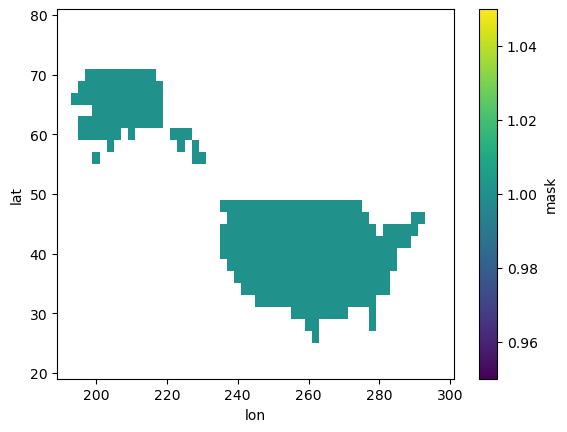

In [354]:
from global_land_mask import globe

lon_mesh,lat_mesh = np.meshgrid(cpcmask['lon'],cpcmask['lat'])
lon_shift = lon_mesh.copy()  # Make a copy to avoid modifying the original 'lon' coordinate

# Apply the shift to the 'lon_shift' variable
lon_shift[lon_shift > 180] = lon_shift[lon_shift > 180] - 360
zmask = np.zeros(lon_mesh.shape)
zmask[np.where(globe.is_land(lat_mesh,lon_shift))] = 1.
zmask[np.where(zmask==0)] = np.nan

dz = xr.Dataset()
dz['mask'] = (('lat','lon'),zmask)
dz['lat'], dz['lon'] = new_lat,new_lon

condition_zmask = np.isnan(dz['mask'])
condition_cpcmask = cpcmask['mask'] == 1.
combined_condition = condition_zmask & condition_cpcmask
cpcmask_mod = xr.where(combined_condition, np.nan, cpcmask.mask.values)
cpcmask_mod.sel(lat=slice(20,80),lon=slice(190,300)).plot()

condition_zmask = dz.mask == 1.
condition_cpcmask = np.isnan(cpcmask.mask) 
combined_condition = condition_zmask & condition_cpcmask
cpcmask_mod = xr.where(combined_condition, np.nan, cpcmask_mod.values)
cpcmask_mod.sel(lat=slice(20,80),lon=slice(190,300)).plot()
cpcmask = cpcmask_mod

In [361]:
cpcmask = xr.DataArray(cpcmask, name="mask")
cpcmask
# cpcmask.mask.sel(lat=slice(20,80),lon=slice(190,300)).plot()
# cpcmask
# plt.contourf(zmask).show()
# dz.mask.sel(lat=40, lon = slice(190,305)).plot()



<xarray.DataArray 'mask' (lat: 91, lon: 180)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [ ]:
# clim = xr.open_dataset('data_clim/tavg.day.1991-2020.ltm.nc')
# clim = xr.concat([clim,clim],dim='time')
# clim
# climroll = clim.drop_vars(['climatology_bounds']).rolling({'time':7},min_periods=int(7//2)).mean()
# climatology = climroll.groupby("time.dayofyear").mean("time")
# climP = xr.open_dataset('data_clim/tavg.day.1981-2010.ltm.nc')
# climP = xr.concat([climP,climP],dim='time')
# climProll = climP.drop_vars(['climatology_bounds']).rolling({'time':7},min_periods=int(7//2)).mean()
# climatologyP = climProll.groupby("time.dayofyear").mean("time")

In [ ]:

anom = obsgroup-climatology
anomP = obsgroup-climatologyP

In [ ]:
latbins = np.mean([cpcmask.lat.data[:-1],cpcmask.lat.data[1:]],axis=0)
lonbins = np.mean([cpcmask.lon.data[:-1],cpcmask.lon.data[1:]],axis=0)

In [ ]:
tmpC = anom.groupby_bins('lat',latbins).mean()
tmpC = tmpC.groupby_bins('lon',lonbins).mean()
tmpC['lat'] = cpcmask.lat.data[1:-1]
tmpC['lon'] = cpcmask.lon.data[1:-1]
tmpC['tavg'].shape
tmpC['tavg'] = tmpC['tavg'].T

tmpP = anomP.groupby_bins('lat',latbins).mean()
tmpP = tmpP.groupby_bins('lon',lonbins).mean()
tmpP['lat'] = cpcmask.lat.data[1:-1]
tmpP['lon'] = cpcmask.lon.data[1:-1]
tmpP['tavg'] = tmpP['tavg'].T

In [ ]:
def fillnan(a):
    amask = np.isnan(a)
    a[amask] = np.interp(np.flatnonzero(amask), np.flatnonzero(~amask), a[~amask])
    return a

def fillzero(a):
    amask = (a==0)
    a[amask] = np.interp(np.flatnonzero(amask), np.flatnonzero(~amask), a[~amask])
    return a  

In [ ]:
LIMpage_path = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_retrospective_8_vars_9e_sliding_climo_no_double_running_mean_add_offset_simple_map'

FCSTDIR = f'{LIMpage_path}/lim_t2m_retrospective/wk34separate_regression' 
PLOTDIR = f'{FCSTDIR}/Images_regression'
SKILLDIR = f'{LIMpage_path}/skill_pickles_regression'
VERIFDIR = f'{FCSTDIR}'
T_INIT = dt(2017,1,1)
lt = [(21,)]
ds = xr.open_dataset(f'{VERIFDIR}/{varname}.{T_INIT:%Y%m%d}.nc')
ds
newds = xr.concat([ds.sel(lead_time='21 days') ],dim='lead_time').mean('lead_time')
anomvar = varname+'_anom'
lon = limlon
lat = limlat
# flatten forecast anomaly and bin to 2degree CPC grid
if len(newds[anomvar].data.shape)>2:
    anom = varobj.flatten(newds[anomvar].data[-1])
else:
    anom = varobj.flatten(newds[anomvar].data[:,:])    
anom = fillnan(anom)
z = anom
# ANOM = interp2CPC(limlat,limlon,anom)
xMin = max([0,min(lon)-5])
yMin = max([-90,min(lat)-5])
xMax = min([360,max(lon)+5])
yMax = min([90,max(lat)+5])
print(xMin,yMin,xMax,yMax)

# # grid the data.
zLL = z[np.argmin((lon-xMin)**2+(lat-yMin)**2)]
zLR = z[np.argmin((lon-xMax)**2+(lat-yMin)**2)]
zUL = z[np.argmin((lon-xMin)**2+(lat-yMax)**2)]
zUR = z[np.argmin((lon-xMax)**2+(lat-yMax)**2)]
lonNew = np.array(list(lon)+[xMin,xMax,xMin,xMax])
latNew = np.array(list(lat)+[yMin,yMin,yMax,yMax])
zNew = np.array(list(z)+[zLL,zLR,zUL,zUR])
zmap = griddata((lonNew,latNew), zNew, (cpcmask.lon.data[None,:], cpcmask.lat.data[:,None]), method='cubic')

out = zmap[np.where(~np.isnan(cpcmask.mask1.data))]
out.

In [ ]:
out.shape
z.shape
print(cpcmask.mask1.data[1:-1,1:-1].shape)
cpcmask.mask1.data[:,:].shape

In [ ]:
cpcmask = xr.open_dataset('data_clim/usa_mask.grid2.nc')
cpcmask


In [ ]:
clim = xr.open_dataset('/Projects/jalbers_process/CPC_data/temp.climo.grid2-areaAvg.1991to2020.nc')
# clim = xr.open_dataset('data_clim/tavg.day.1981-2010.ltm.nc')
# clim = clim.drop_vars(['climatology_bounds'])
# climatology = clim.groupby("time.dayofyear").mean("time")

# clim = xr.concat([clim,clim],dim='time')
# climroll = clim.drop_vars(['climatology_bounds']).rolling({'time':7},min_periods=int(7//2)).mean()

# climroll = clim.rolling({'time':7},min_periods=int(7//2)).mean()
# climatology = climroll.groupby("time.dayofyear").mean("time")

# climroll = clim.drop_vars(['climatology_bounds']).rolling({'time':7},min_periods=int(7//2)).mean()
# climroll = clim.rolling({'time':7},min_periods=int(7//2)).mean()
# climatology = climroll.groupby("time.dayofyear").mean("time")
# clim['time.dayofyear']
print(clim['lon'])

In [ ]:
climatology
clim.groupby("time.dayofyear")
tmpC = clim.groupby_bins('lat',latbins).mean()


In [ ]:
clim2 = xr.open_dataset('/Projects/jalbers_process/CPC_data/temp.climo.grid2-areaAvg.1991to2020.nc')
clim2.lat

In [ ]:
clim = xr.open_dataset('/Projects/jalbers_process/CPC_data/temp.climo.grid2-areaAvg.1991to2020.nc')
dates = xr.cftime_range(start='0001-01-01', end='0001-12-31', freq='D')
clim = xr.DataArray(clim.climo, dims=['time','lat','lon'], 
                      coords={'time': dates, 'lat': clim.lat, 'lon': clim.lon})
# print(clim)
clim = xr.Dataset(data_vars={'tavg': clim})

# print(clim)
# clim.tavg
clim = xr.concat([clim,clim],dim='time') # probably to avoid end point problems in rolling mean
# climroll = clim.drop_vars(['climatology_bounds']).rolling({'time':7},min_periods=int(7//2)).mean()
climroll = clim.rolling({'time':7},min_periods=int(7//2)).mean()
climatology = climroll.groupby("time.dayofyear").mean("time")


In [ ]:
climatology

In [ ]:
anom = obsgroup-climatology

# anom['lat'] = climatology.lat
# anom['lon'] = climatology.lon

anom
# tmpC = anom.groupby_bins('lat',latbins).mean()


In [ ]:
tmpC = anom.groupby_bins('lat',latbins).mean()


In [ ]:
tmpC = anom.groupby_bins('lat',latbins).mean()
tmpC = tmpC.groupby_bins('lon',lonbins).mean()

In [ ]:
climP = xr.open_dataset('data_clim/tavg.day.1981-2010.ltm.nc')
# climP = xr.concat([climP,climP],dim='time')
climP
# climatologyP = climP.groupby("time.dayofyear").mean("time")
# climatologyP

In [ ]:
anomP = obsgroup-climatologyP


In [ ]:
climatologyP.lat
anomP

In [ ]:
tmpP = anomP.groupby_bins('lat',latbins).mean()
